In [1]:
## which python is using
## when using the Nipype_tutorial docker image, it should be "/opt/miniconda-latest/envs/neuro/bin/python"
import sys
sys.executable

'/opt/miniconda-latest/envs/neuro/bin/python'

In [2]:
# get the current machine information
import os
print("System information", os.uname())

System information posix.uname_result(sysname='Linux', nodename='precision-5510', release='4.15.0-96-generic', version='#97-Ubuntu SMP Wed Apr 1 03:25:46 UTC 2020', machine='x86_64')


In [3]:
%matplotlib inline

from nilearn import plotting

from nipype import Node, Workflow # Get the Node and Workflow object
from nipype.algorithms.misc import Gunzip

from nipype.interfaces.matlab import MatlabCommand  # Specify which SPM to use
MatlabCommand.set_default_paths('/opt/spm12-r7219/spm12_mcr/spm12/')
MatlabCommand.set_default_matlab_cmd('matlab -nodesktop -nosplash')

from os.path import join

data_dir = '/media/hcp4715/Data/Data/RepDopa/BIDS/Nifti/'
output_dir = '/media/hcp4715/Data/Data/RepDopa/BIDS/reprod_spm'

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [19]:
# Import the SelectFiles to read data iterately.

#from nipype import SelectFiles

# String template with {}-based strings
#templates = {'anat': 'sub-{subject_id}/ses-d1/anat/'
#                     'sub-{subject_id}_ses-d1_T1w.nii.gz',
#             'func': 'sub-{subject_id}/ses-{ses_id}/func/'
#                     'sub-{subject_id}_ses-{ses_id}_task-{task_id}_bold.nii.gz'}

# Create SelectFiles node
#sf = Node(SelectFiles(templates,
#                      base_directory=data_dir,
#                      sort_filelist=True),
#          name='selectfiles')
#sf.inputs.ses_id='exp'
#sf.inputs.task_id=['exp', 'rest-1', 'rest-2', 'rest-3', 'rest-4']

In [5]:
#ses_list = ['d1', 'd2', 'd3']
#task_list_exp =['exp']
task_list_rest = ['rest-1', 'rest-2', 'rest-3', 'rest-4']
ses_list = ['d2']
subject_list = ['001','002']
sf.iterables = [('subject_id', subject_list),
                ('ses_id', ses_list),
                ('task_id', task_list_rest)]

In [6]:
# specify the model
import nipype.algorithms.modelgen as model
from nipype.interfaces.spm import Level1Design, EstimateModel, EstimateContrast
from nipype.interfaces.io import DataSink


model_spec2 = Node(interface=model.SpecifySPMModel(input_units='scans',
                                                   output_units='scans',
                                                   time_repetition=1,
                                                   high_pass_filter_cutoff=128),
                   name="model_spec2")

# generate a 1st level SPM.mat file for analysis
rsa_1st_level_design2 = Node(interface=Level1Design(bases={'hrf':{'derivs': [1, 0]}},
                                                    timing_units='scans',
                                                    interscan_interval=1,
                                                    model_serial_correlations='AR(1)',
                                                    volterra_expansion_order = 1),
                             name="rsa_1st_level_design2")

# using EstimateModel to determine the parameters of the model
rsa_1st_level_estimate2 = Node(interface=EstimateModel(estimation_method = {'Classical': 1}), 
                              name='rsa_1st_level_estimate2')

In [7]:
## Get events info

# define a function to extract data for design matrix.

def eventinfo(input_dir,subject_id, task_id):  
    import pandas as pd
    import numpy as np
    from nipype.interfaces.base import Bunch
    from os.path import join
    import nibabel as nib
    
    # get the file name
    rest_filename = join(input_dir, 'datasink', 'spm_preproc', 'sub-'+subject_id,'ses-d2', 
                     'swrsub-'+subject_id+'_ses-d2_task-'+task_id+'_bold_roi.nii')
    # load data    
    data = nib.load(rest_filename)
    data.shape
    a = data.shape[3]
    
# be careful about the length and strucutre of each, condition should be a list of string, 
# *not* a list of lists/list
    conditions = []
    onsets = []
    durations = []
    for scan in range(a):
        conditions += ['scans']
        onsets += [[scan+1]]
        durations += [[0]]
    
    #conditions = [['scans']]
    #onsets = [list(range(1, a+1))]     # started from 1
    #durations = [[0] * len(conditions)]
    # using Bunch to put these information together.
    events_info = [Bunch(conditions=conditions,
                          onsets=onsets,
                          durations=durations)]
    
    return events_info

In [11]:
#eventinfo(output_dir, '001','task-rest-1')
#subject_id = '001'
#task_id = 'rest-1'
#rest_filename = join(output_dir, 'datasink', 'spm_preproc', 'sub-'+subject_id,'ses-d2', 
#                     'swrsub-'+subject_id+'_ses-d2_task-'+task_id+'_bold_roi.nii')
#rest_filename

In [12]:
from nipype.interfaces.utility import Function, IdentityInterface

geteventsinfo = Node(Function(input_names=['input_dir','subject_id', 'task_id'],
                               output_names=['events_info'],
                               function=eventinfo),
                      name='geteventsinfo')
geteventsinfo.inputs.input_dir = output_dir

In [25]:
# Infosource - a function free node to interate over the list of subject names
#ses_list = ['d2']


from nipype.interfaces.utility import IdentityInterface
infosource = Node(IdentityInterface(fields=['subject_id',
                                            'ses_id',
                                            'task_id']),
                  name='infosource')

infosource.iterables = [('subject_id', subject_list),
                        ('ses_id', ses_list),
                        ('task_id', task_list_rest)]

# SelectFiles - to grab the preprocessed data

templates = {'func': join(output_dir, 'datasink', 'spm_preproc',
                          'sub-{subject_id}/ses-{ses_id}/swrsub-{subject_id}_ses-{ses_id}_task-{task_id}_bold_roi.nii'),
             'realign_params': join(output_dir, 'datasink', 'spm_preproc',
                                    'sub-{subject_id}/ses-{ses_id}/rp_sub-{subject_id}_ses-{ses_id}_task-{task_id}_bold_roi.txt'),
            }

selectfiles = Node(SelectFiles(templates,
                               base_directory = output_dir,
                               sort_filelist=True),
                   name='selectfiles')

# Datasink - create output folder for important outputs
datasink2 = Node(DataSink(base_directory = output_dir,
                         container='datasink'),
                name='datasink2')

# Use the following DataSink output substitutions
substitutions = [('_subject_id_' , 'sub-')]
subjFolders = [('_ses_id_%ssub-%s_task_id_%s' % (ses_id, sub, task_id), 
                'sub-%s/ses-%s/task-%s' % (sub, ses_id, task_id))
               for sub in subject_list
               for ses_id in ses_list 
               for task_id in task_list_rest]
substitutions.extend(subjFolders)
datasink2.inputs.substitutions = substitutions

In [26]:
#subjFolders = [('_ses_id_%ssub-%s_task_id_%s' % (ses_id, sub, task_id), 'sub-%s/ses-%s/task-%s' % (sub, ses_id, task_id))
#               for sub in subject_list
#               for ses_id in ses_list 
#               for task_id in task_list_rest]
#subjFolders

In [27]:
# Initiation of the 1st-level analysis workflow
rsa_l1_analysis_rest = Workflow(name='rsa_l1_analysis_rest',
                           base_dir=join(output_dir, 'derivatives/'))

# Connect up the 1st-level analysis components
rsa_l1_analysis_rest.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                                    ('ses_id', 'ses_id'),
                                                    ('task_id', 'task_id')]),
                         (infosource, geteventsinfo, [('subject_id', 'subject_id'),
                                                      ('task_id', 'task_id')]),
                         (geteventsinfo, model_spec2, [('events_info', 'subject_info')]),
                         (selectfiles, model_spec2, [('func', 'functional_runs')]),
                         (selectfiles, model_spec2, [('realign_params', 'realignment_parameters')]),
                         (model_spec2, rsa_1st_level_design2, [('session_info', 'session_info')]),
                         (rsa_1st_level_design2, rsa_1st_level_estimate2, [('spm_mat_file', 'spm_mat_file')]),
                         (rsa_1st_level_estimate2, datasink2, [('spm_mat_file', 'rsa_1stLevel_rest.@spm_mat'),
                                                              ]),
                        ]) 

200409-19:38:40,457 nipype.workflow INFO:
	 Generated workflow graph: /media/hcp4715/Data/Data/RepDopa/BIDS/reprod_spm/derivatives/rsa_l1_analysis_rest/graph.png (graph2use=colored, simple_form=True).


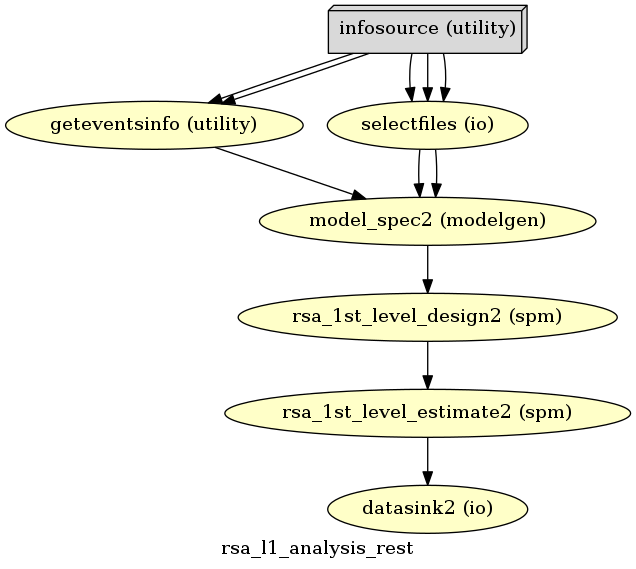

In [28]:
rsa_l1_analysis_rest.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=join(rsa_l1_analysis_rest.base_dir, 'rsa_l1_analysis_rest', 'graph.png'))

In [29]:
rsa_l1_analysis_rest.run('MultiProc', plugin_args={'n_procs': 7})

200409-19:38:44,775 nipype.workflow INFO:
	 Workflow rsa_l1_analysis_rest settings: ['check', 'execution', 'logging', 'monitoring']
200409-19:38:44,841 nipype.workflow INFO:
	 Running in parallel.
200409-19:38:44,845 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 16 jobs ready. Free memory (GB): 28.15/28.15, Free processors: 7/7.
200409-19:38:44,890 nipype.workflow INFO:
	 [Job 0] Cached (rsa_l1_analysis_rest.geteventsinfo).
200409-19:38:44,936 nipype.workflow INFO:
	 [Job 6] Cached (rsa_l1_analysis_rest.geteventsinfo).
200409-19:38:44,936 nipype.workflow INFO:
	 [Node] Setting-up "rsa_l1_analysis_rest.selectfiles" in "/media/hcp4715/Data/Data/RepDopa/BIDS/reprod_spm/derivatives/rsa_l1_analysis_rest/_ses_id_d2_subject_id_002_task_id_rest-4/selectfiles".
200409-19:38:44,944 nipype.workflow INFO:
	 [Job 12] Cached (rsa_l1_analysis_rest.geteventsinfo).
200409-19:38:44,944 nipype.workflow INFO:
	 [Node] Setting-up "rsa_l1_analysis_rest.selectfiles" in "/media/hcp4715/Data/Data/Re


200409-19:38:52,958 nipype.workflow INFO:
	 [Node] Setting-up "rsa_l1_analysis_rest.datasink2" in "/media/hcp4715/Data/Data/RepDopa/BIDS/reprod_spm/derivatives/rsa_l1_analysis_rest/_ses_id_d2_subject_id_002_task_id_rest-2/datasink2".
200409-19:38:52,963 nipype.workflow INFO:
	 [Node] Outdated cache found for "rsa_l1_analysis_rest.datasink2".
200409-19:38:52,966 nipype.workflow INFO:
	 [Node] Running "datasink2" ("nipype.interfaces.io.DataSink")200409-19:38:52,969 nipype.workflow INFO:
	 [Job 22] Cached (rsa_l1_analysis_rest.rsa_1st_level_estimate2).

200409-19:38:52,971 nipype.workflow INFO:
	 [Node] Finished "rsa_l1_analysis_rest.datasink2".
200409-19:38:52,974 nipype.interface INFO:
	 sub: /media/hcp4715/Data/Data/RepDopa/BIDS/reprod_spm/datasink/rsa_1stLevel_rest/_ses_id_d2_subject_id_002_task_id_rest-3/SPM.mat -> /media/hcp4715/Data/Data/RepDopa/BIDS/reprod_spm/datasink/rsa_1stLevel_rest/sub-002/ses-d2/task-rest-3/SPM.mat
200409-19:38:52,978 nipype.workflow INFO:
	 [Job 28] Cached

200409-19:39:02,920 nipype.workflow INFO:
	 [Node] Setting-up "rsa_l1_analysis_rest.datasink2" in "/media/hcp4715/Data/Data/RepDopa/BIDS/reprod_spm/derivatives/rsa_l1_analysis_rest/_ses_id_d2_subject_id_001_task_id_rest-1/datasink2".
200409-19:39:02,923 nipype.workflow INFO:
	 [Node] Outdated cache found for "rsa_l1_analysis_rest.datasink2".
200409-19:39:02,930 nipype.workflow INFO:
	 [Node] Running "datasink2" ("nipype.interfaces.io.DataSink")
200409-19:39:02,934 nipype.interface INFO:
	 sub: /media/hcp4715/Data/Data/RepDopa/BIDS/reprod_spm/datasink/rsa_1stLevel_rest/_ses_id_d2_subject_id_001_task_id_rest-1/SPM.mat -> /media/hcp4715/Data/Data/RepDopa/BIDS/reprod_spm/datasink/rsa_1stLevel_rest/sub-001/ses-d2/task-rest-1/SPM.mat
200409-19:39:02,944 nipype.workflow INFO:
	 [Node] Finished "rsa_l1_analysis_rest.datasink2".
200409-19:39:04,862 nipype.workflow INFO:
	 [Job 47] Completed (rsa_l1_analysis_rest.datasink2).
200409-19:39:04,872 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks